In [1]:

import os
import sys
import re
import random
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.nn import GCNConv, GINConv, TopKPooling, Sequential
from torch_geometric.nn import (
    global_mean_pool as gap,
    global_max_pool as gmp,
    global_sort_pool as gsp,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error as MSE, mean_absolute_percentage_error as MAPE
from scipy.stats import zscore

In [2]:
GPU_NUM = 6
torch.cuda.set_device(GPU_NUM)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(
        f"90server: {torch.cuda.get_device_name()} - cuda({torch.cuda.current_device()}) v{torch.version.cuda} is available"
    )
    print(f"Torch version: {torch.__version__}")
    print(f"Count of using GPUs:", torch.cuda.device_count())
    print()
else:
    print("Can not use GPU device!")
    device = torch.device("cpu")

90server: TITAN V - cuda(6) v10.2 is available
Torch version: 1.9.1+cu102
Count of using GPUs: 8



In [3]:
PATH        = "/nasdata4/pei4/feature_selection_gnn/experiments"
suffix      = '9'
saving_path = PATH + "/experiment_" + suffix

In [18]:
data_path = '/nasdata4/pei4/feature_selection_gnn/sample_data/'

# 데이터 파일 읽어오기
subjects_list = open(data_path + 'subjects_list.txt', 'r')
subjects_list = subjects_list.read()
subjects_list = subjects_list.split('\n')

subjects_diag = open(data_path + 'subjects_diagnosis.txt', 'r')
subjects_diag = subjects_diag.read()
subjects_diag = subjects_diag.split('\n')

snp_Additive    = pd.read_csv(data_path + 'Data01_SNPs_Additive.csv')
snp_GENEgroups  = pd.read_csv(data_path + 'Data02_SNPs_GENEgroups.csv')
subcor_volumes  = pd.read_csv(data_path + 'Data04_Subcortical_volumes_ICVcorrected.csv')
normal_subcor_volumes  = pd.read_csv(data_path + 'Data04_Subcortical_volumes_ICVcorrected_Normalized.csv')

# 데이터 합치기
smaple_data_features = []
for sbj, label in zip(subjects_list, subjects_diag):
    edge_feature5       = np.loadtxt(f'{data_path}edge_index5/{sbj}_edge_index.txt', dtype=int)
    edge_feature10      = np.loadtxt(f'{data_path}edge_index10/{sbj}_edge_index.txt', dtype=int)
    edge_feature15      = np.loadtxt(f'{data_path}edge_index15/{sbj}_edge_index.txt', dtype=int)
    edge_feature20      = np.loadtxt(f'{data_path}edge_index20/{sbj}_edge_index.txt', dtype=int)
    node_feature_pcc    = np.loadtxt(f'{data_path}x_partialCC/pcc_ROISignals_{sbj}.txt', delimiter=",")
    node_feature_bold   = np.loadtxt(f'{data_path}x_roi_signal/ROISignals_{sbj}.txt')

    graph_label = int(label[-1])

    temp = snp_Additive.loc[snp_Additive['IID'] == sbj]
    snp_data = temp.get(temp.columns[6:]).to_numpy()    # 3001개의 SNP값만 쏙 읽어오기

    temp = subcor_volumes.loc[subcor_volumes['IID'] == sbj]
    subcor_data = temp.get(temp.columns[1:]).to_numpy(dtype=float)  # 8개의 볼륨값만 쏙 읽어오기

    temp = normal_subcor_volumes.loc[normal_subcor_volumes['IID'] == sbj]
    normal_subcor_data = temp.get(temp.columns[1:]).to_numpy(dtype=float)  # 8개의 볼륨값만 쏙 읽어오기

    smaple_data_features.append([sbj,                   # [0]
                                 node_feature_pcc,      # [1]
                                 node_feature_bold,     # [2]
                                 edge_feature5,         # [3]
                                 edge_feature10,        # [4]
                                 edge_feature15,        # [5]
                                 edge_feature20,        # [6]
                                 graph_label,           # [7]
                                 snp_data,              # [8]
                                 subcor_data,           # [9]
                                 normal_subcor_data     # [10]
                                 ])

# 데이터 저장
smaple_data_features = np.asarray(smaple_data_features, dtype=object)
print(smaple_data_features[0][10].shape )
#np.save(data_path + 'smaple_data_features.npy', smaple_data_features)

(1, 8)


# Define functions and classes

In [6]:
class my_dataset(Dataset):
    def __init__(self, data_path, node_feature_type="pcor", edge_sparse_type=5, snp_data_type="real", qt_data_type='norm', num_fold=5):
        super(my_dataset, self).__init__()
        self.node_feature_type  = node_feature_type
        self.edge_sparse_type   = edge_sparse_type
        self.snp_data_type      = snp_data_type
        self.qt_data_type       = qt_data_type

        snp_Additive    = pd.read_csv(data_path + 'Data01_SNPs_Additive.csv')   # snp additive 정보 읽어오기
        snp_GENEgroups  = pd.read_csv(data_path + 'Data02_SNPs_GENEgroups.csv') # snp gene group 정보 읽어오기
        add_snp_list    = snp_Additive.columns[6:].to_list()                    # csv파일에서 FID, IID, PAT, MAT, SEX, PHENOTYPE 제외한 SNP정보만 추출
        gene_group      = dict(zip(list(snp_GENEgroups.SNPID), list(snp_GENEgroups.GENEgroup))) # {SNP명 : group 번호} 생성
        # gene_group_list = list(snp_GENEgroups.SNPID)    # group 번호 정보를 담은 list data 생성

        self.snp_group = []
        for snp_name in add_snp_list:
            self.snp_group.append(gene_group[snp_name[:-2]])    # SNP명을 key로 받는 dicionary를 이용해서 add_snp_list의 SNP명 순서로 group 번호 할당
        self.snp_group_data = torch.tensor(self.snp_group, dtype=torch.long)

        self.my_Data = []
        self.num_sbj    = 157
        self.num_QT     = 8
        self.num_snp    = 3001

        smaple_data_features = np.load(data_path + 'smaple_data_features.npy', allow_pickle=True)
        for subject_data in smaple_data_features:
            if node_feature_type == "pcor":
                node_feature = subject_data[1]
            else:   # "bold"
                node_feature = subject_data[2]

            if edge_sparse_type == 5:
                edge_idx = subject_data[3]
            elif edge_sparse_type == 10:
                edge_idx = subject_data[4]
            elif edge_sparse_type == 15:
                edge_idx = subject_data[5]
            else:
                edge_idx = subject_data[6]

            graph_label = subject_data[7]

            if self.snp_data_type == "real":
                snp_data = subject_data[8]
            else:
                snp_data = torch.randint(0, 3, size=(157, 3001)).to(device=device)
                torch.save(snp_data, data_path + "/fake_snp_data.pt")

            if self.qt_data_type == "raw":
                t1_measure  = subject_data[9]
            else:
                t1_measure  = subject_data[10]

            # numpy to tensor
            node_feature    = torch.Tensor(node_feature).transpose(0, 1)
            graph_label     = torch.tensor(graph_label, dtype=torch.long)
            edge_idx        = torch.Tensor(edge_idx).transpose(0, 1)
            fc_data         = Data(x=node_feature, edge_index=edge_idx.long(), y=graph_label).to(device=device)

            snp_data    = torch.Tensor(snp_data).to(device=device)
            t1_measure  = torch.Tensor(t1_measure).to(device=device)
            snp_data    = torch.squeeze(snp_data)
            t1_measure  = torch.squeeze(t1_measure)

            self.my_Data.append([fc_data, snp_data, t1_measure])

        rand_state = 42
        self.num_fold = num_fold
        skf = StratifiedKFold(n_splits=self.num_fold, shuffle=True, random_state=rand_state)

        y_idx = []
        for i in range(self.num_sbj):
            y_idx.append(self.my_Data[i][0].y.item())

        self.train_dataset  = []
        self.test_dataset   = []
        self.y_train = []
        for train_idx, test_idx in skf.split(range(self.num_sbj), y_idx):
            for i in train_idx:
                self.train_dataset.append([self.my_Data[i][0], self.my_Data[i][1], self.my_Data[i][2]])
                self.y_train.append(self.my_Data[i][0].y.item())
            for j in test_idx:
                self.test_dataset.append([self.my_Data[j][0], self.my_Data[j][1], self.my_Data[j][2]])
            break

    # 인덱스에 해당되는 데이터를 tensor 형태로 반환
    def __getitem__(self, idx):
        fc_map = self.my_Data[idx][0]
        minor_allele_cnt = self.my_Data[idx][1]
        t1_meausre = self.my_Data[idx][2]

        return fc_map, minor_allele_cnt, t1_meausre

    # 데이터 총 개수 반환
    def __len__(self):
        return len(self.num_sbj)

In [7]:
class Input_layer(nn.Module):
    def __init__(self, n_QT=10, n_snp=3000):#?
        super().__init__()
        self.n_QT = n_QT
        self.n_snp = n_snp

        self.weights = torch.rand(1, self.n_QT, self.n_snp).to(device) #? 작은 값곱하기
        self.weights = nn.Parameter(self.weights, requires_grad=True).cuda()

    def forward(self, x):
        return x * self.weights.mean(dim=1)

In [8]:
class feature_selection_GNN(nn.Module):
    def __init__(self, **kwargs):
        super(feature_selection_GNN, self).__init__()
        # define kwargs
        self.num_features = (
            kwargs["num_features"] if "num_features" in kwargs.keys() else 116
        )
        self.num_classes = (
            kwargs["num_classes"] if "num_classes" in kwargs.keys() else 4
        )
        self.pooling_ratio = (
            kwargs["pooling_ratio"] if "pooling_ratio" in kwargs.keys() else 0.5
        )
        self.n_QT = kwargs["n_QT"] if "n_QT" in kwargs.keys() else 8
        self.n_snp = kwargs["n_snp"] if "n_snp" in kwargs.keys() else 3001

        self.gnn_model = (
            kwargs["gnn_model"] if "gnn_model" in kwargs.keys() else "gcn"
        )

        conv1_out_channels = 50
        conv2_out_channels = 50
        # define layers
        if self.gnn_model == "gcn":
            self.conv1 = GCNConv(in_channels=self.num_features, out_channels=conv1_out_channels)
            self.conv2 = GCNConv(in_channels=conv1_out_channels, out_channels=conv1_out_channels)
        elif self.gnn_model == "gin":
            self.conv1 = GINConv(nn.Sequential(nn.Linear(self.num_features, conv1_out_channels), nn.ReLU(), nn.Linear(conv1_out_channels, conv1_out_channels)))
            self.conv2 = GINConv(nn.Sequential(nn.Linear(conv1_out_channels, conv2_out_channels), nn.ReLU(), nn.Linear(conv2_out_channels, conv2_out_channels)))
            
        self.pool1 = TopKPooling(
            in_channels=conv1_out_channels, ratio=self.pooling_ratio
        )
        self.pool2 = TopKPooling(conv2_out_channels, ratio=self.pooling_ratio)
        self.input = Input_layer(n_QT=self.n_QT, n_snp=self.n_snp)
        self.fc1 = nn.Linear(in_features=self.input.n_snp, out_features=500)
        self.bn1 = nn.BatchNorm1d(self.fc1.out_features)
        self.fc2 = nn.Linear(
            in_features=self.fc1.out_features, out_features=self.input.n_QT
        )
        self.fc3 = nn.Linear(700, out_features=conv1_out_channels)
        self.bn2 = nn.BatchNorm1d(self.fc3.out_features)
        self.fc4 = nn.Linear(
            in_features=self.fc3.out_features, out_features=self.num_classes
        )

        # custom layer initialization
        nn.init.xavier_normal_(self.input.weights)  #바꾸기

    def forward(self, data):
        x = data[0].x
        edge_index = data[0].edge_index
        x_snp = data[1]
        batch = (
            data[0].batch
            if hasattr(data[0], "batch")
            else torch.tensor((), dtype=torch.long).new_zeros(data[0].num_nodes)
        )  #??

        # start here
        x1 = self.conv1(x, edge_index)
        x1, edge_index, edge_attr, batch, perm, score1 = self.pool1(
            x1, edge_index, batch=batch
        )
        x2 = self.conv2(x1, edge_index)
        x1_gmp = gmp(x1, batch)
        x1_gap = gap(x1, batch)
        x1 = torch.cat([x1_gmp, x1_gap], dim=1)
        x2, edge_index, edge_attr, batch, perm, score2 = self.pool2(
            x2, edge_index, batch=batch
        )
        x2 = torch.cat([gmp(x2, batch), gap(x2, batch)], dim=1)
        xx = torch.cat([x1, x2], dim=1)
        x_snp = F.relu(self.input(x_snp))
        x_snp = F.relu(self.bn1(self.fc1(x_snp)))
        xx = torch.cat([x_snp, xx], dim=1)
        xx = self.bn2(self.fc3(xx))

        reg = F.relu(self.fc2(x_snp))
        cls = F.log_softmax(self.fc4(xx), dim=-1)

        return reg, cls

In [9]:
class WeightConstraint(object):
    def __init__(self):
        pass

    def __call__(self, module):
        if hasattr(module, 'weights'):
            w = module.weights.data
            w = w.clamp(1e-9, None)
            module.weights.data = w

In [10]:
def regularity(U, LD, num_QT, a, b, c):
    abc_sum = np.round(a + b + c, 2)
    if (a >= 0.0) and (b >= 0.0) and (c >= 0.0) and abc_sum == 1.0:
        pass
    else:
        raise Exception("Value error! The sum of a,b,c, must be 1.")

    LD_group = torch.unique(LD)

    # 빈 dictionary 생성
    indexed_U = {}
    for i in LD_group:
        indexed_U[i.item()] = []

    for i, key in enumerate(LD):
        temp = torch.tensor(0, dtype=float, requires_grad=True)
        for t in range(num_QT):
            temp_for_grad = temp.clone()
            temp_for_grad = temp + U[i, t] ** 2
        indexed_U[key.item()].append(temp_for_grad)

    group_sparsity = torch.tensor(0, dtype=float, requires_grad=True)
    for k in LD_group:
        temp = torch.sum(torch.tensor(indexed_U[k.item()]))
        temp_for_grad = temp.clone()
        temp_2 = torch.sqrt(temp_for_grad)
        temp_for_grad_2 = temp_2.clone()
        group_sparsity_for_grad = group_sparsity.clone
        group_sparsity_for_grad = group_sparsity + temp_for_grad_2

    group_sparsity = group_sparsity_for_grad

    individual_sparsity = torch.square(U)  # 3000 by 10
    individual_sparsity = torch.sum(
        individual_sparsity, 1
    )  # 1은 한 행의 모든 값들을 더함. -> 3000 by 1
    individual_sparsity = torch.sqrt(individual_sparsity)
    individual_sparsity = torch.sum(individual_sparsity, 0)  # 0은 한 열의 모든 값들을 더함.

    element_sparsity = torch.abs(U)
    element_sparsity = torch.sum(element_sparsity, 1)
    element_sparsity = torch.sum(element_sparsity, 0)

    return group_sparsity, individual_sparsity, element_sparsity

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch
    """

    def __init__(self, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.verbose = verbose
        self.flag = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.flag += self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            pass
        else:
            self.best_score = score
            self.flag += self.save_checkpoint(val_loss, model)

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        return 1

In [18]:
# Old train 

def trainer(dataset, skf2, batch_size=16, num_features=2, num_classes=3, learning_rate=0.001, epochs=500, a=0.4, b=0.3, c=0.3, save_path="/nasdata4/pei4/feature_selection_gnn", gnn_model="gcn"):
    history = []
    epoch_flag = []
    for fold, (train_idx, val_idx) in enumerate(skf2.split(dataset.train_dataset, dataset.y_train)):
        saving_file_path = save_path + "/checkpoint_" + str(fold + 1) + "_" + suffix + ".pt"
        early_stopping = EarlyStopping(verbose=True, path=saving_file_path)

        print()
        print("Fold {}".format(fold + 1))
        train_sampler   = SubsetRandomSampler(train_idx)
        val_sampler     = SubsetRandomSampler(val_idx)

        if len(val_sampler) <= batch_size:
            batch_size_val = len(val_sampler)
        else:
            batch_size_val = batch_size

        train_loader    = DataLoader(dataset.train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
        val_loader      = DataLoader(dataset.train_dataset, batch_size=batch_size_val, sampler=val_sampler, drop_last=True)
        net             = feature_selection_GNN(num_features=num_features, num_classes=num_classes, n_snp=dataset.num_snp, gnn_model=gnn_model).to(device)
        constraints     = WeightConstraint()  ##?

        reg_criterion   = nn.MSELoss()
        cls_criterion   = nn.CrossEntropyLoss()
        optimizer       = optim.Adam(net.parameters(), lr=learning_rate)  ##weight decay

        for epoch in range(epochs):
            # clear lists to track next epoch
            train_losses = []
            valid_losses = []

            run_tr_reg_loss = 0
            run_tr_cls_loss = 0
            run_tr_r1_loss  = 0
            run_tr_r2_loss  = 0
            run_tr_r3_loss  = 0

            run_vl_reg_loss = 0
            run_vl_cls_loss = 0
            run_vl_r1_loss  = 0
            run_vl_r2_loss  = 0
            run_vl_r3_loss  = 0
            ###################
            # train the model #
            ###################
            net.train()
            for i, data in enumerate(train_loader, 0):
                train_clinical_score = data[2]

                # generate output
                train_reg_output, train_cls_output = net(data)

                # calculate regularity loss
                U = net.input.weights.squeeze()
                U = torch.transpose(U, 0, 1)
                alpha, beta, gamma = regularity(U, dataset.snp_group_data, dataset.num_QT, a, b, c)
                regularity_loss = a*alpha + b*beta + c*gamma

                # calculate regression loss
                train_reg_loss = reg_criterion(train_reg_output.squeeze(), train_clinical_score)

                # calculate classification loss
                train_cls_loss = cls_criterion(train_cls_output, data[0].y)


                train_loss = train_reg_loss + (0.5 * train_cls_loss) + regularity_loss

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
                net._modules["input"].apply(constraints)  # Input_layer parameter만 제한 #??

                run_tr_reg_loss += train_cls_loss
                run_tr_cls_loss += train_reg_loss  #??append해서 len(train_loader)로 나눠주기
                run_tr_r1_loss  += alpha
                run_tr_r2_loss  += beta
                run_tr_r3_loss  += gamma

            run_tr_reg_loss = torch.mean(run_tr_reg_loss).item()  
            run_tr_cls_loss = torch.mean(run_tr_cls_loss).item()
            run_tr_r1_loss  = torch.mean(run_tr_r1_loss).item()
            run_tr_r2_loss  = torch.mean(run_tr_r2_loss).item()
            run_tr_r3_loss  = torch.mean(run_tr_r3_loss).item()
            train_losses.append([run_tr_reg_loss, run_tr_cls_loss, run_tr_r1_loss, run_tr_r2_loss, run_tr_r3_loss])

            ######################
            # validate the model #
            ######################
            net.eval()
            for i, data in enumerate(val_loader, 0):
                val_clinical_score = data[2]

                # generate output
                val_reg_output, val_cls_output = net(data)

                # calculate regularity loss
                U = net.input.weights.squeeze()
                U = torch.transpose(U, 0, 1)
                alpha, beta, gamma = regularity(U, dataset.snp_group_data, dataset.num_QT, a, b, c)
                regularity_loss = a*alpha + b*beta + c*gamma

                # calculate regression loss
                valid_reg_loss = reg_criterion(val_reg_output.squeeze(), val_clinical_score)

                # calculate classification loss
                valid_cls_loss = cls_criterion(val_cls_output, data[0].y)
                valid_loss = valid_reg_loss + (0.5 * valid_cls_loss) + regularity_loss  #생각해보기

                run_vl_reg_loss += valid_cls_loss #수정
                run_vl_cls_loss += valid_reg_loss
                run_vl_r1_loss  += alpha
                run_vl_r2_loss  += beta
                run_vl_r3_loss  += gamma

            run_vl_reg_loss = torch.mean(run_vl_reg_loss).item()
            run_vl_cls_loss = torch.mean(run_vl_cls_loss).item()
            run_vl_r1_loss  = torch.mean(run_vl_r1_loss).item()
            run_vl_r2_loss  = torch.mean(run_vl_r2_loss).item()
            run_vl_r3_loss  = torch.mean(run_vl_r3_loss).item()
            valid_losses.append([run_vl_reg_loss, run_vl_cls_loss, run_vl_r1_loss, run_vl_r2_loss, run_vl_r3_loss])

            # print message
            epoch_len = len(str(epochs))
            print_msg = (
                f"[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] "
                + f"\ttrain_loss: {train_loss:.5f} "
                + f"\tvalid_loss: {valid_loss:.5f}"
            )

            print(print_msg)

            # early_stopping는 validation loss가 감소하였는지 확인이 필요하며, 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
            early_stopping(valid_loss, net)
            # best model이 저장되어있는 last checkpoint를 로드
            net.load_state_dict(torch.load(saving_file_path))

        epoch_flag.append(early_stopping.flag)
        history.append([train_losses, valid_losses])
        print("Fold {} training is done.".format(fold + 1))

    print("Finished Training")
    print()

    return net, history, epoch_flag

In [ ]:
# New trainer by yeji

def trainer(dataset, skf2, batch_size=16, num_features=2, num_classes=3, learning_rate=0.001, a=0.4, b=0.3, c=0.3, save_path="/nasdata4/pei4/feature_selection_gnn", gnn_model="gcn"):
    history = []
    for fold, (train_idx, val_idx) in enumerate(skf2.split(dataset.train_dataset, dataset.y_train)):
        saving_file_path = save_path + "/checkpoint_" + str(fold + 1) + "_" + suffix + ".pt"

        print()
        print("Fold {}".format(fold + 1))
        
        train_dataset = []
        val_dataset = []
        
        for i in train_idx:
            train_dataset.append([dataset.train_dataset[i][0], dataset.train_dataset[i][1], dataset.train_dataset[i][2]])
    
        for j in val_idx:
            val_dataset.append([dataset.train_dataset[j][0], dataset.train_dataset[j][1], dataset.train_dataset[j][2]])
        
        
        ##SGD 할 필요 없을거 같다는 생각, sampler도 없앰
        ###왜 val, train 모두 train dataset되어 있나? --> val_dataset 만들어야
        train_loader    = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) 
        val_loader      = DataLoader(val_dataset, batch_size=10*batch_size, drop_last=True)
        net             = feature_selection_GNN(num_features=num_features, num_classes=num_classes, n_snp=dataset.num_snp, gnn_model=gnn_model).to(device)
        #constraints     = WeightConstraint()  ##?

        reg_criterion   = nn.MSELoss()
        cls_criterion   = nn.CrossEntropyLoss()
        optimizer       = optim.Adam(net.parameters(), lr=learning_rate)  ##weight decay

            # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        run_tr_reg_loss = 0
        run_tr_cls_loss = 0
        run_tr_r1_loss  = 0
        run_tr_r2_loss  = 0
        run_tr_r3_loss  = 0

        run_vl_reg_loss = 0
        run_vl_cls_loss = 0
        run_vl_r1_loss  = 0
        run_vl_r2_loss  = 0
        run_vl_r3_loss  = 0
        ###################
        # train the model #
        ###################
        net.train()
        for i, data in enumerate(train_loader, 0):
            train_clinical_score = data[2]

            # generate output
            train_reg_output, train_cls_output = net(data)

            # calculate regularity loss
            U = net.input.weights.squeeze()
            U = torch.transpose(U, 0, 1)
            alpha, beta, gamma = regularity(U, dataset.snp_group_data, dataset.num_QT, a, b, c)
            regularity_loss = a*alpha + b*beta + c*gamma
            
            # calculate regression loss
            train_reg_loss = reg_criterion(train_reg_output.squeeze(), train_clinical_score)

            # calculate classification loss
            train_cls_loss = cls_criterion(train_cls_output, data[0].y)


            train_loss = (0.5*train_reg_loss) + (0.5 * train_cls_loss) + regularity_loss

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            #net._modules["input"].apply(constraints)  # Input_layer parameter만 제한 #??음수는 나올수 있는 듯

            run_tr_reg_loss += train_cls_loss
            run_tr_cls_loss += train_reg_loss  #??append해서 len(train_loader)로 나눠주기
            run_tr_r1_loss  += alpha
            run_tr_r2_loss  += beta
            run_tr_r3_loss  += gamma

            run_tr_reg_loss = torch.mean(run_tr_reg_loss).item()  
            run_tr_cls_loss = torch.mean(run_tr_cls_loss).item()
            run_tr_r1_loss  = torch.mean(run_tr_r1_loss).item()
            run_tr_r2_loss  = torch.mean(run_tr_r2_loss).item()
            run_tr_r3_loss  = torch.mean(run_tr_r3_loss).item()
            train_losses.append([run_tr_reg_loss, run_tr_cls_loss, run_tr_r1_loss, run_tr_r2_loss, run_tr_r3_loss])

            ######################
            # validate the model #
            ######################
            net.eval()
            for i, data in enumerate(val_loader, 0):
                val_clinical_score = data[2]

                # generate output
                val_reg_output, val_cls_output = net(data)

                # calculate regularity loss
                U = net.input.weights.squeeze()
                U = torch.transpose(U, 0, 1)
                alpha, beta, gamma = regularity(U, dataset.snp_group_data, dataset.num_QT, a, b, c)
                regularity_loss = a*alpha + b*beta + c*gamma

                # calculate regression loss
                valid_reg_loss = reg_criterion(val_reg_output.squeeze(), val_clinical_score)

                # calculate classification loss
                valid_cls_loss = cls_criterion(val_cls_output, data[0].y)
                valid_loss = valid_reg_loss + (0.5 * valid_cls_loss) + regularity_loss  #생각해보기

                run_vl_reg_loss += valid_cls_loss #수정
                run_vl_cls_loss += valid_reg_loss
                run_vl_r1_loss  += alpha
                run_vl_r2_loss  += beta
                run_vl_r3_loss  += gamma

            run_vl_reg_loss = torch.mean(run_vl_reg_loss).item()
            run_vl_cls_loss = torch.mean(run_vl_cls_loss).item()
            run_vl_r1_loss  = torch.mean(run_vl_r1_loss).item()
            run_vl_r2_loss  = torch.mean(run_vl_r2_loss).item()
            run_vl_r3_loss  = torch.mean(run_vl_r3_loss).item()
            valid_losses.append([run_vl_reg_loss, run_vl_cls_loss, run_vl_r1_loss, run_vl_r2_loss, run_vl_r3_loss])

            # print message
            epoch_len = len(str(epochs))
            print_msg = (
                f"[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] "
                + f"\ttrain_loss: {train_loss:.5f} "
                + f"\tvalid_loss: {valid_loss:.5f}"
            )

            print(print_msg)

            # early_stopping는 validation loss가 감소하였는지 확인이 필요하며, 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
            #early_stopping(valid_loss, net)
            # best model이 저장되어있는 last checkpoint를 로드
            #net.load_state_dict(torch.load(saving_file_path))

        #epoch_flag.append(early_stopping.flag)
        history.append([train_losses, valid_losses])
        print("Fold {} training is done.".format(fold + 1))

    print("Finished Training")
    print()

    return net, history, epoch_flag

In [13]:
#Old tester

def tester(net, num_splits, test_loader, save_path):
    cls_acc_list = []
    reg_acc_list = []

    with torch.no_grad():  #확인
        for fold in range(num_splits):
            saving_file_path = save_path + "/checkpoint_" + str(fold + 1) + "_" + suffix + ".pt"
            net.load_state_dict(torch.load(saving_file_path))
            net.eval()

            pred_cls = []
            pred_reg = []

            true_cls = []
            true_reg = []

            for i, data in enumerate(test_loader, 0):
                true_cls.append(data[0].y.item())
                true_reg.append(data[2].cpu().detach().numpy())

                pred_reg_output, pred_cls_output = net(data)

                pred_cls_output = torch.exp(pred_cls_output)  #찾아보기
                pred_cls_output = pred_cls_output.cpu().detach().numpy()
                pred_reg_output = pred_reg_output.cpu().detach().numpy()

                pred_cls_output = np.argmax(pred_cls_output, axis=None)
                pred_cls.append(pred_cls_output)
                pred_reg.append(pred_reg_output)

            true_reg = np.asarray(true_reg)
            pred_reg = np.asarray(pred_reg)
            true_reg = np.squeeze(true_reg)
            pred_reg = np.squeeze(pred_reg)

            cls_acc = accuracy_score(true_cls, pred_cls)
            reg_acc_MSE = MSE(true_reg, pred_reg)

            cls_acc_list.append(cls_acc)
            reg_acc_list.append(reg_acc_MSE)

            print('Fold {}'.format(fold + 1))
            print(f"==>> cls acc: {cls_acc}")
            print(f"==>> reg acc(MSE): {reg_acc_MSE}")
            print('True :', true_reg)
            print('Pred :', pred_reg)
            print(f"")
        print(f"==================")
        print(f"==>> mean cls acc: {np.mean(cls_acc_list):.2f}")
        print(f"==>> mean reg acc(MSE): {np.mean(reg_acc_list):.2f}")

    mean_accuracy = [np.mean(cls_acc_list), np.mean(reg_acc_list)]

    return cls_acc_list, reg_acc_list, mean_accuracy

In [ ]:
## New tester by Yeji

def tester(net, num_splits, test_loader, save_path):
    cls_acc_list = []
    reg_acc_list = []

    with torch.no_grad():  #확인
        for fold in range(num_splits):
            #saving_file_path = save_path + "/checkpoint_" + str(fold + 1) + "_" + suffix + ".pt"
            #net.load_state_dict(torch.load(saving_file_path))
            net.eval()

            pred_cls = []
            pred_reg = []

            true_cls = []
            true_reg = []

            for i, data in enumerate(test_loader, 0):
                true_cls.append(data[0].y.item())
                true_reg.append(data[2].cpu().detach().numpy())

                pred_reg_output, pred_cls_output = net(data)

                pred_cls_output = torch.exp(pred_cls_output)  #찾아보기
                pred_cls_output = pred_cls_output.cpu().detach().numpy()
                pred_reg_output = pred_reg_output.cpu().detach().numpy()

                pred_cls_output = np.argmax(pred_cls_output, axis=None)
                pred_cls.append(pred_cls_output)
                pred_reg.append(pred_reg_output)

            true_reg = np.asarray(true_reg)
            pred_reg = np.asarray(pred_reg)
            true_reg = np.squeeze(true_reg)
            pred_reg = np.squeeze(pred_reg)

            cls_acc = accuracy_score(true_cls, pred_cls)
            reg_acc_MSE = MSE(true_reg, pred_reg)

            cls_acc_list.append(cls_acc)
            reg_acc_list.append(reg_acc_MSE)

            print('Fold {}'.format(fold + 1))
            print(f"==>> cls acc: {cls_acc}")
            print(f"==>> reg acc(MSE): {reg_acc_MSE}")
            print('True :', true_reg)
            print('Pred :', pred_reg)
            print(f"")
        print(f"==================")
        print(f"==>> mean cls acc: {np.mean(cls_acc_list):.2f}")
        print(f"==>> mean reg acc(MSE): {np.mean(reg_acc_list):.2f}")

    mean_accuracy = [np.mean(cls_acc_list), np.mean(reg_acc_list)]

    return cls_acc_list, reg_acc_list, mean_accuracy

In [14]:
class U_matrix_similarity(object):
    def __init__(self, LD_group):
        self.LD_group = LD_group

    def __call__(self, num_features, num_classes, num_snp, save_path, num_fold, gnn_model):
        U_list = []
        for i in range(num_fold):
            temp_net_path = save_path + "/checkpoint_" + str(i + 1) + "_" + suffix + ".pt"
            temp_net = feature_selection_GNN(num_features=num_features, num_classes=num_classes, n_snp=num_snp, gnn_model=gnn_model).to(device)
            temp_net.load_state_dict(torch.load(temp_net_path))
            U = temp_net.input.weights.squeeze()
            U = U.cpu().detach().numpy()
            # U[np.where(U < 0)] = 0
            U_hat = self.group_count(self.binarization(self.row_wise_normalization(U), 0.9), self.LD_group)
            U_list.append(U_hat)
        sim_mat = np.ones((num_fold, num_fold))
        for i, mat_A in enumerate(U_list):
            for j, mat_B in enumerate(U_list):
                sim_mat[i][j] = np.round(self.row_wise_inner_product(mat_A, mat_B), 3)
        self.print_figure(sim_mat, save_path)

    def NormalizeData(self, data):
        if (np.max(data) - np.min(data)) == 0:
            return 0
        else:
            return (data - np.min(data)) / (np.max(data) - np.min(data))

    def row_wise_normalization(self, data):
        temp = np.empty(data.shape)
        for i, row in enumerate(data):
            temp[i] = self.NormalizeData(row)
        return temp
    
    def binarization(self, data, threshold=0):
        data[np.where(data > threshold)] = 1
        return data

    def group_count(self, data, Group):
        # Group_min = Group[np.argmin(Group)]  # 1
        Group_max = Group[np.argmax(Group)]  # 29
        temp = np.zeros((data.shape[0], Group_max.item())) # 10 by 29
        for i, row in enumerate(data):
            data[i] = row * Group.T
            unique_val_arr, cnt_arr = np.unique(data[i], return_counts=True)
            unique_val_arr = np.asarray(unique_val_arr, dtype=int)
            unique_val_arr = np.delete(unique_val_arr, 0, axis=0)
            cnt_arr = np.delete(cnt_arr, 0, axis=0)
            for j, idx in enumerate(unique_val_arr):
                temp[i][idx-1] = cnt_arr[j]
        return temp

    def row_wise_inner_product(self, mat_A, mat_B):
        sim_vec = []
        for i, (A, B) in enumerate(zip(mat_A, mat_B)):
            row_wise_similarity = np.sum(A * B) / (np.linalg.norm(A) * np.linalg.norm(B))
            sim_vec.append(row_wise_similarity)
        return np.mean(sim_vec)

    def print_figure(self, data, save_path):
        plt.figure(figsize=(10, 10))
        sns.heatmap(data, annot=True, fmt=".2f", cmap='Blues')
        plt.title("U matrix similarity")
        plt.savefig(save_path + "/U matrix similarity_" + suffix + ".png", dpi=600)

# Set parameters

In [16]:
torch.manual_seed(0) #인자로 받아 올 수 있게
np.random.seed(0)

node_feature_type   = 'bold'
edge_sparse_type    = 5
snp_data_type       = 'real'
QT_type             = 'norm'
data_path           = '/nasdata4/pei4/feature_selection_gnn/sample_data/'

dataset = my_dataset(
    data_path, node_feature_type=node_feature_type, edge_sparse_type=edge_sparse_type, snp_data_type=snp_data_type
)
os.popen('mkdir ' + saving_path)

# define hyper parameter
num_classes     = 3
num_features    = dataset.train_dataset[0][0].x.shape[1]
learning_rate   = 0.0004
epochs          = 100
batch_size      = 4
num_splits      = 4
alpha           = 0.3
beta            = 0.3
gamma           = 0.4
gnn_model       = 'gcn'

rand_state  = random.seed(time.time())  ##수정 + torch.manual_seed
skf2        = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=rand_state)
test_loader = DataLoader(dataset.test_dataset)


print(f"")
print(f"=============================")
print(f"==== Dataset Information ====")
print(f"=============================")
print(f"number of subjects : {dataset.num_sbj}")
print(f"number of QT : {dataset.num_QT}")
print(f"number of SNPs : {dataset.num_snp}")
print(f"number of classes : {num_classes}")
print(f"number of node features : {num_features}")
print(f"node feature type : {dataset.node_feature_type}")
print(f"edge sparsity type : {dataset.edge_sparse_type}")
print(f"snp data type : {dataset.snp_data_type}")
print(f"QT data type : {dataset.qt_data_type}")
print(f"")
print(f"==============================")
print(f"====== Hyper parameters ======")
print(f"==============================")
print(f"learning rate : {learning_rate}")
print(f"number of epochs : {epochs}")
print(f"size of batch : {batch_size}")
print(f"number of folds : {num_splits}")
print(f"regularity term ratio (a) : {alpha}")
print(f"regularity term ratio (b) : {beta}")
print(f"regularity term ratio (c) : {gamma}")
print(f"baseline gnn model : {gnn_model}")
print(f"")


==== Dataset Information ====
number of subjects : 157
number of QT : 8
number of SNPs : 3001
number of classes : 3
number of node features : 135
node feature type : bold
edge sparsity type : 5
snp data type : real
QT data type : norm

====== Hyper parameters ======
learning rate : 0.0004
number of epochs : 100
size of batch : 4
number of folds : 4
regularity term ratio (a) : 0.3
regularity term ratio (b) : 0.3
regularity term ratio (c) : 0.4
baseline gnn model : gcn



mkdir: cannot create directory ‘/nasdata4/pei4/feature_selection_gnn/experiments/experiment_9’: File exists


# Training

In [19]:
net, history, epoch_flag = trainer(
    dataset=dataset,
    skf2=skf2,
    batch_size=batch_size,
    num_features=num_features,
    num_classes=num_classes,
    learning_rate=learning_rate,
    epochs=epochs,
    a=alpha,
    b=beta,
    c=gamma,
    save_path=saving_path,
    gnn_model=gnn_model
)
folds_cls_acc, folds_reg_acc, mean_acc = tester(net, num_splits, test_loader, saving_path)


Fold 1
[  0/100] 	train_loss: 11.59277 	valid_loss: 10.60253
Validation loss decreased (inf --> 10.602528).  Saving model...
[  1/100] 	train_loss: 1.46127 	valid_loss: 1.42386
Validation loss decreased (10.602528 --> 1.423860).  Saving model...
[  2/100] 	train_loss: 0.59709 	valid_loss: 0.60490
Validation loss decreased (1.423860 --> 0.604898).  Saving model...
[  3/100] 	train_loss: 0.54693 	valid_loss: 0.53641
Validation loss decreased (0.604898 --> 0.536408).  Saving model...
[  4/100] 	train_loss: 0.60130 	valid_loss: 0.59400
[  5/100] 	train_loss: 0.45507 	valid_loss: 0.59292
[  6/100] 	train_loss: 0.52210 	valid_loss: 0.55534
[  7/100] 	train_loss: 0.38702 	valid_loss: 0.60503
[  8/100] 	train_loss: 0.50230 	valid_loss: 0.62250
[  9/100] 	train_loss: 0.44864 	valid_loss: 0.63464
[ 10/100] 	train_loss: 0.65054 	valid_loss: 0.60822
[ 11/100] 	train_loss: 0.51607 	valid_loss: 0.55426
[ 12/100] 	train_loss: 0.52931 	valid_loss: 0.59409
[ 13/100] 	train_loss: 0.49989 	valid_loss: 0

# Test

In [107]:
def printFigure(num_splits, history, net, save_path):
    fig, axs = plt.subplots(4, 5, figsize=(15, 15))
    for fold in range(num_splits):
        train_reg_loss  = np.asarray(history[fold][0][0])
        train_cls_loss  = np.asarray(history[fold][0][1])
        train_r1_loss   = np.asarray(history[fold][0][2])
        train_r2_loss   = np.asarray(history[fold][0][3])
        train_r3_loss   = np.asarray(history[fold][0][4])

        valid_reg_loss  = np.asarray(history[fold][1][0])
        valid_cls_loss  = np.asarray(history[fold][1][1])
        valid_r1_loss   = np.asarray(history[fold][1][2])
        valid_r2_loss   = np.asarray(history[fold][1][3])
        valid_r3_loss   = np.asarray(history[fold][1][4])

        x_axix          = np.linspace(1, len(train_reg_loss), len(train_reg_loss))

        # train & valid losses
        plt.subplot(4, 5, 3*fold + 1)
        X1 = train_reg_loss + train_cls_loss + train_r1_loss + train_r2_loss + train_r3_loss
        X2 = valid_reg_loss + valid_cls_loss + valid_r1_loss + valid_r2_loss + valid_r3_loss
        plt.plot(x_axix, X1, label="train")
        plt.plot(x_axix, X2, label="valid")
        plt.legend()

        # training -> regress & cls & regul losses
        plt.subplot(4, 5, 3*fold + 2)
        X1 = train_reg_loss
        X2 = train_cls_loss
        X3 = train_r1_loss + train_r2_loss + train_r3_loss
        plt.plot(x_axix, X1, label="train_regress")
        plt.plot(x_axix, X2, label="train_cls")
        plt.plot(x_axix, X3, label="train_regul")
        plt.legend()

        # validation -> regress & cls & regul losses
        plt.subplot(4, 5, 3*fold + 3)
        X1 = valid_reg_loss
        X2 = valid_cls_loss
        X3 = valid_r1_loss + valid_r2_loss + valid_r3_loss
        plt.plot(x_axix, X1, label="valid_regress")
        plt.plot(x_axix, X2, label="valid_cls")
        plt.plot(x_axix, X3, label="valid_regul")
        plt.legend()

        # training -> regularity term losses
        plt.subplot(4, 5, 5*fold + 4)
        X1 = train_r1_loss
        X2 = train_r2_loss
        X3 = train_r3_loss
        plt.plot(x_axix, train_r1_loss, label="train_r1")
        plt.plot(x_axix, train_r2_loss, label="train_r2")
        plt.plot(x_axix, train_r3_loss, label="train_r3")
        plt.legend()

        # validation -> regularity term losses
        plt.subplot(4, 5, 5*(fold + 1))
        X1 = valid_r1_loss
        X2 = valid_r2_loss
        X3 = valid_r3_loss
        plt.plot(x_axix, valid_r1_loss, label="valid_r1")
        plt.plot(x_axix, valid_r2_loss, label="valid_r2")
        plt.plot(x_axix, valid_r3_loss, label="valid_r3")
        plt.legend()

    # plt.savefig(save_path + "/train_valid_loss_" + suffix + ".png", dpi=400)

    fig, axs = plt.subplots(4, 1, figsize=(30, 24))
    for fold in range(num_splits):
        file_load_path = save_path + "/checkpoint_" + str(fold + 1) + "_" + suffix + ".pt"
        net.load_state_dict(torch.load(file_load_path))
        plt.subplot(4, 1, fold + 1)
        U = net.input.weights.squeeze()
        U = U.cpu().detach().numpy()
        U[np.where(U < 0)] = 0
        sns.heatmap(U)

    # plt.savefig(save_path + "/snp_inputlayer_param_" + suffix + ".png", dpi=400)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


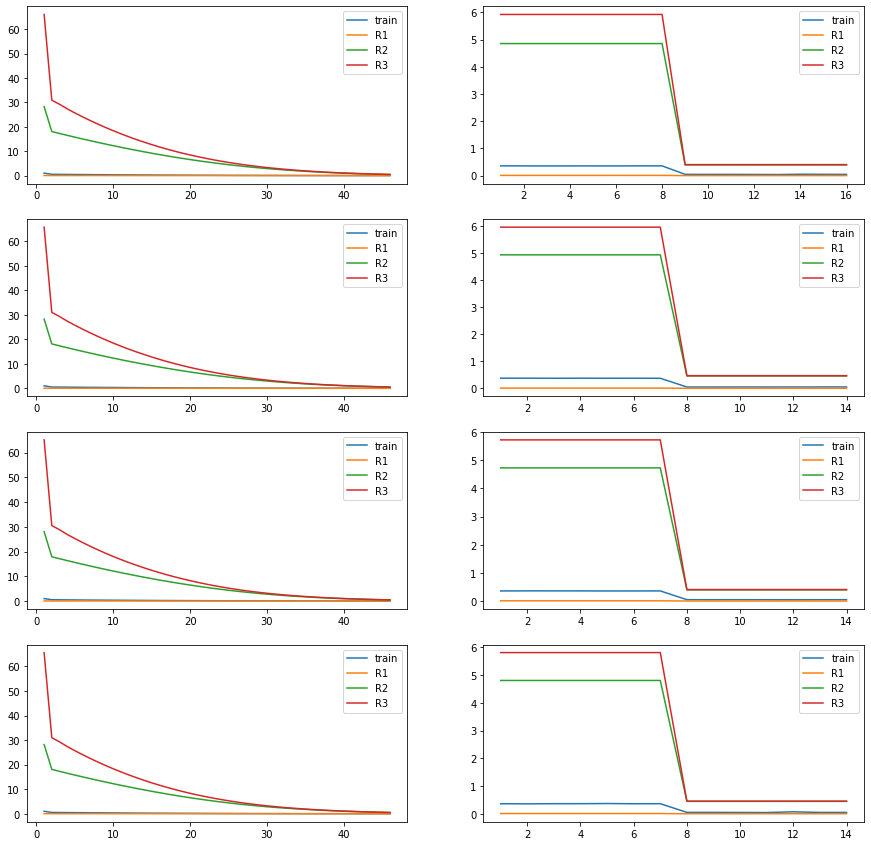

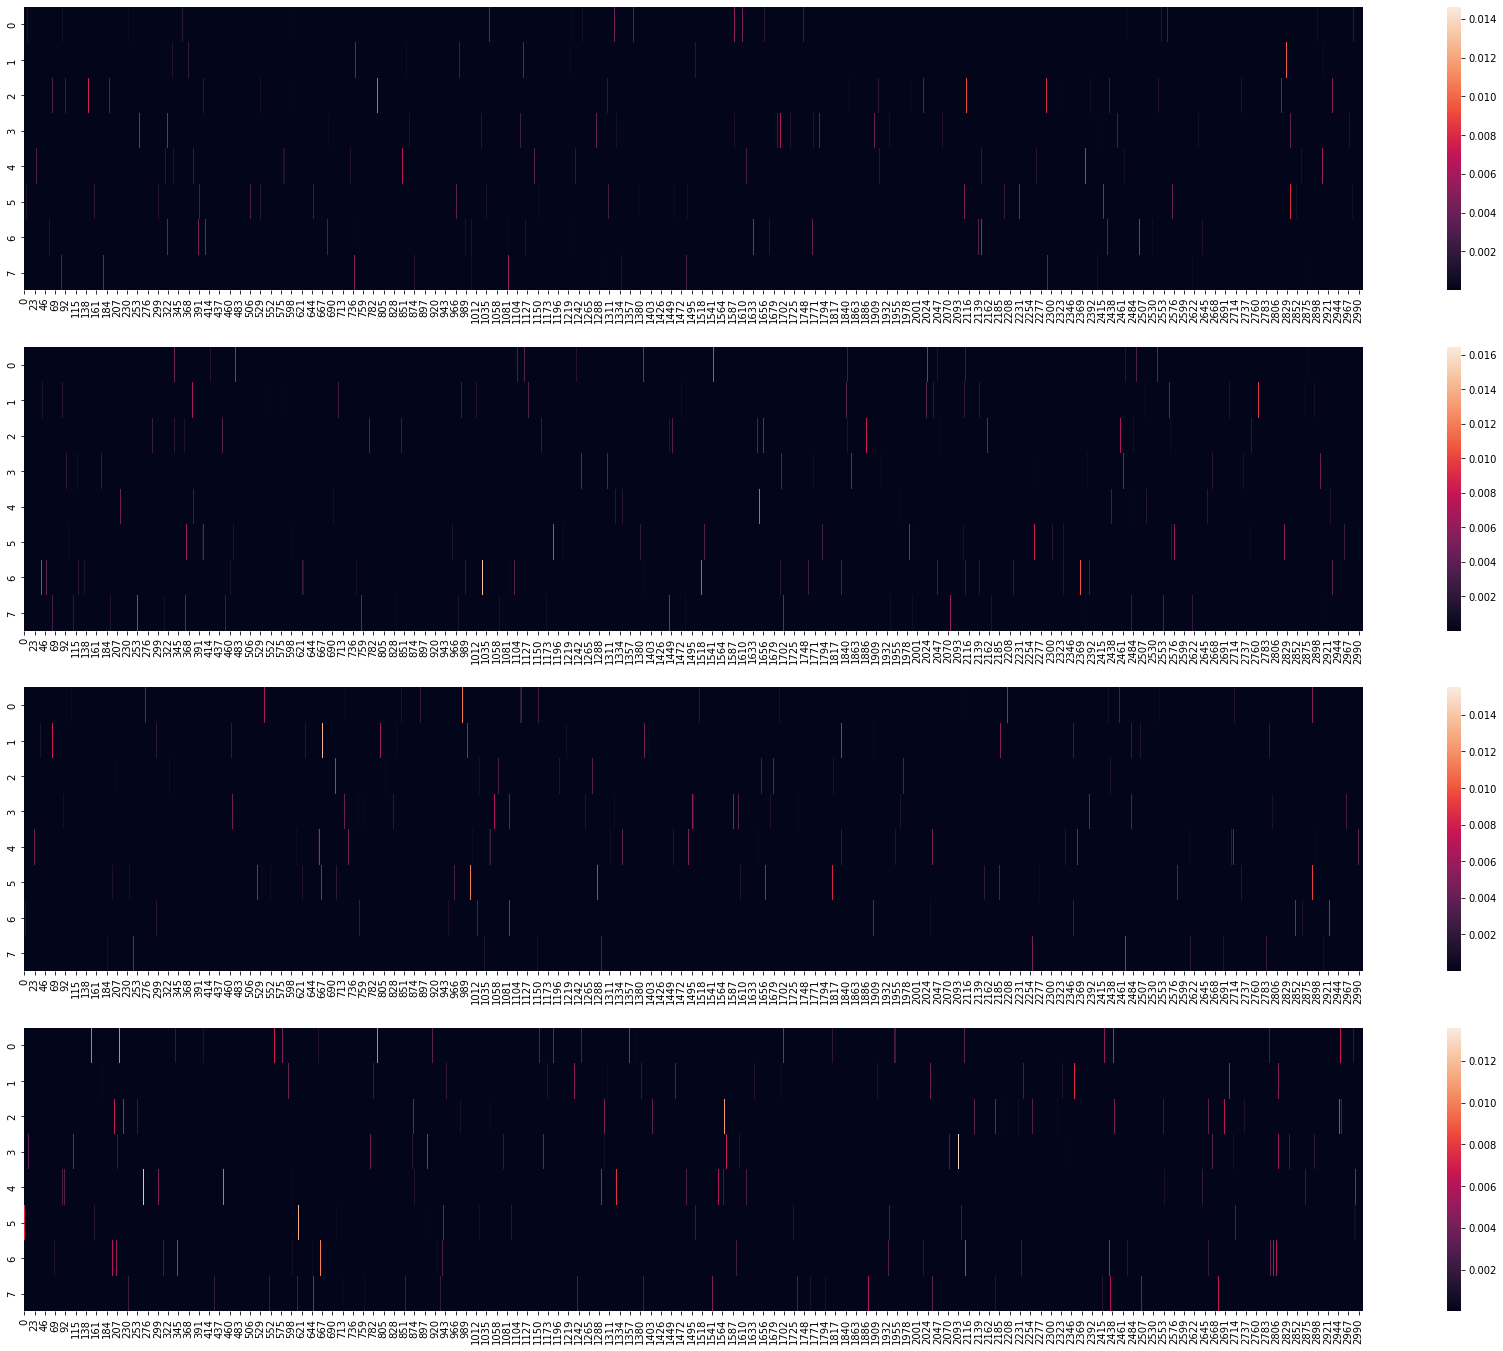

In [109]:
#folds_cls_acc, folds_reg_acc, mean_acc = tester(net, num_splits, test_loader, saving_path)
printFigure(num_splits, history, net, saving_path)

In [ ]:
gene_group = dataset.snp_group_data.cpu().detach().numpy()
calc_ld = U_matrix_similarity(LD_group=gene_group)
calc_ld(num_features, num_classes, dataset.num_snp, saving_path, num_splits, gnn_model)

# Save training parameters and test results

In [106]:
training_info = pd.DataFrame(
    {
        'Experiment No.' : [suffix],
        'Node feature' : [dataset.node_feature_type],
        'Edge sparsity' : [dataset.edge_sparse_type],
        'SNP data type' : [dataset.snp_data_type],
        'QT data type' : [dataset.qt_data_type],
        'Regularity term ratio (A)' : [alpha],
        'Regularity term ratio (B)' : [beta],
        'Regularity term ratio (C)' : [gamma],
        'Batch size' : [batch_size],
        'Learning Rate' : [learning_rate],
        'Baseline model' : [gnn_model],
        'Fold 1 epochs' : [epoch_flag[0]],
        'Fold 1 cls accuracy' : [folds_cls_acc[0]],
        'Fold 1 reg accuracy' : [folds_reg_acc[0]],
        'Fold 2 epochs' : [epoch_flag[1]],
        'Fold 2 cls accuracy' : [folds_cls_acc[1]],
        'Fold 2 reg accuracy' : [folds_reg_acc[1]],
        'Fold 3 epochs' : [epoch_flag[2]],
        'Fold 3 cls accuracy' : [folds_cls_acc[2]],
        'Fold 3 reg accuracy' : [folds_reg_acc[2]],
        'Fold 4 epochs' : [epoch_flag[3]],
        'Fold 4 cls accuracy' : [folds_cls_acc[3]],
        'Fold 4 reg accuracy' : [folds_reg_acc[3]],
        'Mean cls accuracy' : mean_acc[0],
        'Mean reg accuracy' : mean_acc[1]
    }
)

training_info.to_csv(saving_path + '/training_info.csv')

IndexError: list index out of range

### normalization 방법에 따른 QT 데이터 생성

In [ ]:
def NormalizeData(data):
    if (np.max(data) - np.min(data)) == 0:
        return 0
    else:
        return (data - np.min(data)) / (np.max(data) - np.min(data))

QT = pd.read_csv('/nasdata4/pei4/feature_selection_gnn/sample_data/Data04_Subcortical_volumes_ICVcorrected.csv')
QT_rawdata = np.asarray(QT)
QT_rawdata = QT_rawdata.transpose()
print(QT_rawdata.shape)
QT_vol_data = QT_rawdata[1:]
print(QT_vol_data.shape)
temp = np.empty(QT_vol_data.shape)

for i, volumes in enumerate(QT_vol_data):
    temp[i] = NormalizeData(volumes)

temp_2 = QT_rawdata[0]
print(temp_2)
temp_2 = np.expand_dims(temp_2, axis=0)
temp = np.concatenate((temp_2, temp), axis=0)
temp = temp.transpose()
normalized_volumes = pd.DataFrame(temp, columns = QT.columns, index=None)
normalized_volumes.to_csv('/nasdata4/pei4/feature_selection_gnn/sample_data/Data04_Subcortical_volumes_ICVcorrected_Normalized.csv', index=False)

In [239]:
# U_list = []
# for i in range(4):
#     temp_net_path = "/nasdata4/pei4/feature_selection_gnn/experiments/experiment_9/checkpoint_" + str(i + 1) + "_9.pt"
#     print(temp_net_path)
#     temp_net = feature_selection_GNN(num_features=num_features, num_classes=num_classes, n_snp=3001, gnn_model=gnn_model).to(device)
#     temp_net.load_state_dict(torch.load(temp_net_path))
#     U = temp_net.input.weights.squeeze()
#     U = U.cpu().detach().numpy()
#     # temp = self.row_wise_normalization(U)
#     # print(temp)
#     # temp = self.binarization(temp, 0)
#     # print(temp)
#     # temp = self.group_count(temp, self.LD_group)
#     # print(temp)
#     U_hat = group_count(self.binarization(self.row_wise_normalization(U), 0), self.LD_group)
#     U_list.append(U_hat)

#     break
# # sim_mat = np.ones((num_fold, num_fold))
# # for i, mat_A in enumerate(U_list):
# #     for j, mat_B in enumerate(U_list):
# #         sim_mat[i][j] = np.round(self.row_wise_inner_product(mat_A, mat_B), 3)
# # self.print_figure(sim_mat, save_path)